# Introduction

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# depend on tensorflow 2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Flatten, Reshape, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Set number of GPUs

In [2]:
import os
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
# print out local devices visible to TensorFlow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13385794922265022531, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10787610057377504615
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6599151492268524625
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15651402548
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14931080267745862296
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:0a:00.0, compute capability: 7.0"]

# Data

## load genotype

In [4]:
# get genotype col names
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
with open(vcf_file, 'r') as f_vcf:
    while True:
        line = f_vcf.readline()
        if line[:2]!='##':
            break

    col_names = line[1:].split()
        
# print(col_names)

In [5]:
# load genotype
vcf_file = 'data/ADNI_JansenNG_33gene_unimputed.vcf'
vcf_genotype = pd.read_csv(
    vcf_file,
    sep='\t',
    header=None,
    names=col_names,
    comment='#')

vcf_genotype

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0/0,...,0/1,1/1,0/0,0/0,0/1,0/1,0/0,0/0,0/1,0/0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,0/1,...,0/1,1/1,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0/0,...,0/1,0/0,0/1,0/0,0/1,0/1,0/1,0/1,0/1,0/0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,0/1,...,0/1,0/1,0/0,0/1,0/1,0/1,0/1,1/1,0/1,0/1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0/0,...,0/0,0/1,1/1,0/1,0/0,0/0,0/0,0/0,0/1,0/1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,0/1,...,0/1,0/0,0/0,0/0,0/1,0/1,0/1,0/0,0/0,0/0


In [6]:
# replace genotype with integers
vcf_int = vcf_genotype.replace({
    './.': np.NaN,
    '0/0': 0,
    '0/1': 1,
    '1/0': 1,
    '1/1': 2
})

vcf_int

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2_123_S_0108,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,1,161111931,rs10908824,A,G,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
1,1,161116022,rs11589567,G,T,.,.,PR,GT,0,...,1,2,0,0,1,1,0,0,1,0
2,1,161122903,rs4656988,G,A,.,.,PR,GT,1,...,1,2,1,0,1,1,1,1,1,0
3,1,161135421,rs3402,C,T,.,.,PR,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,161135559,rs2502806,G,A,.,.,PR,GT,0,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,20,55057904,rs6064401,G,A,.,.,PR,GT,1,...,1,1,0,1,1,1,1,2,1,1
1779,20,55062564,rs6092321,A,G,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1780,20,55072472,rs6024911,G,A,.,.,PR,GT,0,...,0,1,2,1,0,0,0,0,1,1
1781,20,55078533,rs3827108,T,C,.,.,PR,GT,1,...,1,0,0,0,1,1,1,0,0,0


In [7]:
# snp matrix with shape of (SNP loci, individual)
snp_ind_matrix = vcf_int.iloc[:, 9:]
snp_ind_matrix

,2_123_S_0108,2_024_S_0985,2_131_S_0123,2_098_S_0160,2_027_S_0256,2_116_S_1243,2_073_S_2264,2_094_S_2216,2_021_S_0337,2_141_S_1255,...,2_141_S_1245,2_941_S_1194,2_941_S_1295,2_941_S_1311,2_941_S_1363,2_002_S_4264,2_021_S_2077,2_024_S_4186,2_128_S_2057,2_941_S_4066
0,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
1,0,0,1,2,0,0,1,0,0,1,...,1,2,0,0,1,1,0,0,1,0
2,1,0,1,2,0,0,1,0,1,1,...,1,2,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,2,1,1,1,1,1,...,1,0,1,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1,2,1,0,0,2,1,2,1,1,...,1,1,0,1,1,1,1,2,1,1
1779,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1780,0,0,0,0,1,0,0,0,0,1,...,0,1,2,1,0,0,0,0,1,1
1781,1,0,1,2,1,0,1,0,1,0,...,1,0,0,0,1,1,1,0,0,0


In [8]:
# transposition is necessary.
ind_snp_matrix = snp_ind_matrix.transpose()
ind_snp_matrix

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_123_S_0108,0,0,1,0,0,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_0985,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
2_131_S_0123,1,1,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_098_S_0160,2,2,2,0,0,2,2,0,0,2,...,2,2,2,2,2,0,0,0,2,0
2_027_S_0256,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_002_S_4264,1,1,1,0,1,1,1,0,0,1,...,0,0,0,1,1,1,0,0,1,1
2_021_S_2077,0,0,1,0,1,1,1,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_4186,0,0,1,0,1,1,0,1,1,0,...,0,0,0,0,0,2,0,0,0,2
2_128_S_2057,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,1,1,0,1


## load phenotype

In [9]:
# load phenotype
MMSE_file = 'data/MMSE_selected.csv'
MMSE_data = pd.read_csv(MMSE_file, sep=',', header=0)
MMSE_data = MMSE_data.dropna()
MMSE_data

,RID,MMSCORE
0,31,30.0
1,35,29.0
2,47,1.0
3,51,23.0
4,58,29.0
...,...,...
930,5283,28.0
931,5287,29.0
932,5288,1.0
933,5290,1.0


In [10]:
MMSE_data['MMSCORE'].describe()

count    932.000000
mean      23.346567
std        9.835547
min        1.000000
25%       24.000000
50%       28.000000
75%       29.000000
max       30.000000
Name: MMSCORE, dtype: float64

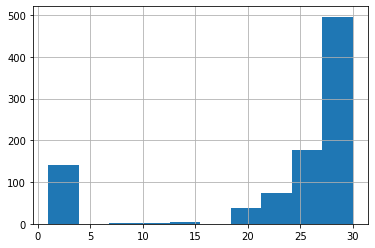

In [11]:
# This phenotype is clearly categoried into two groups
# Thus, it is better to perform classification first, then predict MMSE score in each group.
MMSE_data['MMSCORE'].hist()

In [12]:
Y = np.asarray(MMSE_data['MMSCORE'])

In [13]:
# normlization
Y = (Y - Y.min()) / (Y.max() - Y.min())

## Intersection

In [14]:
genetic_id = [x[-4:] for x in ind_snp_matrix.index]
rid = ['{:04d}'.format(x) for x in MMSE_data['RID']]

In [15]:
row_id = [genetic_id.index(x) for x in rid]

In [16]:
X = ind_snp_matrix.iloc[row_id, :]
X

,0,1,2,3,4,5,6,7,8,9,...,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
2_023_S_0031,1,1,1,0,1,1,1,0,0,1,...,2,2,2,2,2,0,0,0,2,0
2_100_S_0035,0,0,1,0,1,1,0,1,1,0,...,1,1,1,1,1,1,0,0,1,1
2_100_S_0047,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,1
2_099_S_0051,2,2,2,1,0,2,2,0,0,2,...,0,1,1,1,1,1,0,0,1,1
2_023_S_0058,0,0,0,0,2,0,0,0,0,0,...,1,0,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_036_S_5283,2,2,2,1,0,2,2,0,0,2,...,1,2,2,2,2,0,0,0,2,0
2_053_S_5287,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,1
2_027_S_5288,0,0,0,0,2,0,0,0,0,0,...,1,1,1,1,1,1,0,0,1,1
2_024_S_5290,1,1,1,1,1,1,1,0,0,1,...,1,1,1,1,1,1,0,0,1,1


## Onehot encode

In [17]:
## One-hot encoding
X_onehot = to_categorical(X)
X_onehot.shape

(932, 1783, 3)

## Split train and test

In [18]:
# split df to train and valid
X_train, X_test, Y_train, Y_test = train_test_split(
    X_onehot, Y, test_size=0.2)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((745, 1783, 3), (187, 1783, 3), (745,), (187,))

In [19]:
# split df to train and valid
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, test_size=0.2)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((596, 1783, 3), (149, 1783, 3), (596,), (149,))

# Method 

## Build model

In [20]:
# hyperparameters
batch_size = 16
learning_rate = 0.01
epochs = 100

# conv 1D
num_kernels = 16
feature_size = X_train.shape[1]
inChannel = X_train.shape[2]
kr = 1e-4
drop_prec = 0.50

In [21]:
regressor = Sequential()

regressor.add(
    Conv1D(num_kernels,
           5,
           padding='same',
           activation='relu',
           kernel_regularizer=l1(kr),
           input_shape=(feature_size, inChannel)))
regressor.add(BatchNormalization())
regressor.add(AveragePooling1D(pool_size=2))
# regressor.add(Dropout(drop_prec))

regressor.add(Flatten())
regressor.add(Dense(feature_size, activation='relu',
                    kernel_regularizer=l1(kr)))
regressor.add(BatchNormalization())
# regressor.add(Dropout(drop_prec))

regressor.add(
    Dense(int(feature_size / 2), activation='relu', kernel_regularizer=l1(kr)))
regressor.add(BatchNormalization())
regressor.add(Dense(1))

#compile
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# optimizer=tf.keras.optimizers.Adam(learning_rate)

#summary
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1783, 16)          256       
_________________________________________________________________
batch_normalization (BatchNo (None, 1783, 16)          64        
_________________________________________________________________
average_pooling1d (AveragePo (None, 891, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 14256)             0         
_________________________________________________________________
dense (Dense)                (None, 1783)              25420231  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1783)              7132      
_________________________________________________________________
dense_1 (Dense)              (None, 891)               1

## Training

In [22]:
regressor_fit = regressor.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_valid, Y_valid),
    # callbacks=[EarlyStopping, ModelCheckpoint]
)

Train on 596 samples, validate on 149 samples
Epoch 1/100
596/596 [==============================] - 4s 7ms/sample - loss: 42.4624 - mse: 12.8503 - val_loss: 31.2587 - val_mse: 0.7815
Epoch 2/100
596/596 [==============================] - 0s 540us/sample - loss: 34.9968 - mse: 4.5258 - val_loss: 30.5445 - val_mse: 0.2520
Epoch 3/100
596/596 [==============================] - 0s 543us/sample - loss: 31.6909 - mse: 1.6965 - val_loss: 29.7990 - val_mse: 0.1780
Epoch 4/100
596/596 [==============================] - 0s 519us/sample - loss: 29.8212 - mse: 0.5673 - val_loss: 28.9901 - val_mse: 0.1670
Epoch 5/100
596/596 [==============================] - 0s 526us/sample - loss: 28.6339 - mse: 0.2436 - val_loss: 28.1080 - val_mse: 0.2008
Epoch 6/100
596/596 [==============================] - 0s 528us/sample - loss: 27.6319 - mse: 0.1606 - val_loss: 27.1192 - val_mse: 0.1483
Epoch 7/100
596/596 [==============================] - 0s 537us/sample - loss: 26.6442 - mse: 0.1363 - val_loss: 26.1558 

596/596 [==============================] - 0s 530us/sample - loss: 2.8590 - mse: 0.0795 - val_loss: 2.8855 - val_mse: 0.1323
Epoch 60/100
596/596 [==============================] - 0s 538us/sample - loss: 3.2054 - mse: 0.0796 - val_loss: 3.2231 - val_mse: 0.1398
Epoch 61/100
596/596 [==============================] - 0s 549us/sample - loss: 3.2184 - mse: 0.0726 - val_loss: 3.1011 - val_mse: 0.1742
Epoch 62/100
596/596 [==============================] - 0s 573us/sample - loss: 2.8905 - mse: 0.0718 - val_loss: 2.7651 - val_mse: 0.1388
Epoch 63/100
596/596 [==============================] - 0s 529us/sample - loss: 2.5492 - mse: 0.0632 - val_loss: 2.4844 - val_mse: 0.1426
Epoch 64/100
596/596 [==============================] - 0s 519us/sample - loss: 2.3762 - mse: 0.0608 - val_loss: 2.3002 - val_mse: 0.1328
Epoch 65/100
596/596 [==============================] - 0s 531us/sample - loss: 2.2554 - mse: 0.0610 - val_loss: 2.2711 - val_mse: 0.1394
Epoch 66/100
596/596 [=========================

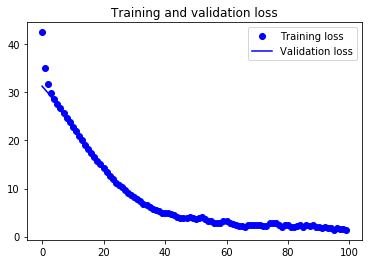

In [23]:
# plot loss curve on validation data
loss = regressor_fit.history['loss']
val_loss = regressor_fit.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'bo', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

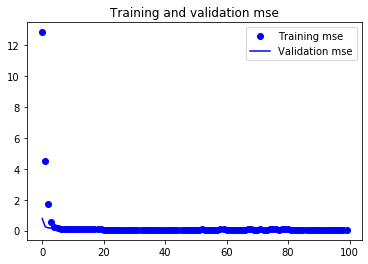

In [24]:
# plot accuracy curve on validation data
mse = regressor_fit.history['mse']
val_mse = regressor_fit.history['val_mse']
plt.figure()
plt.plot(range(len(mse)), mse, 'bo', label='Training mse')
plt.plot(range(len(val_mse)), val_mse, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.show()

# Prediction

In [25]:
# predict
Y_predict = regressor.predict(X_test)

In [26]:
len(Y_test)

187

In [27]:
# r_square
r2_score(Y_test,Y_predict[:,0])

-0.23901158370831177

In [28]:
mean_squared_error(Y_test,Y_predict[:,0])

0.12936678874680377

# Plot

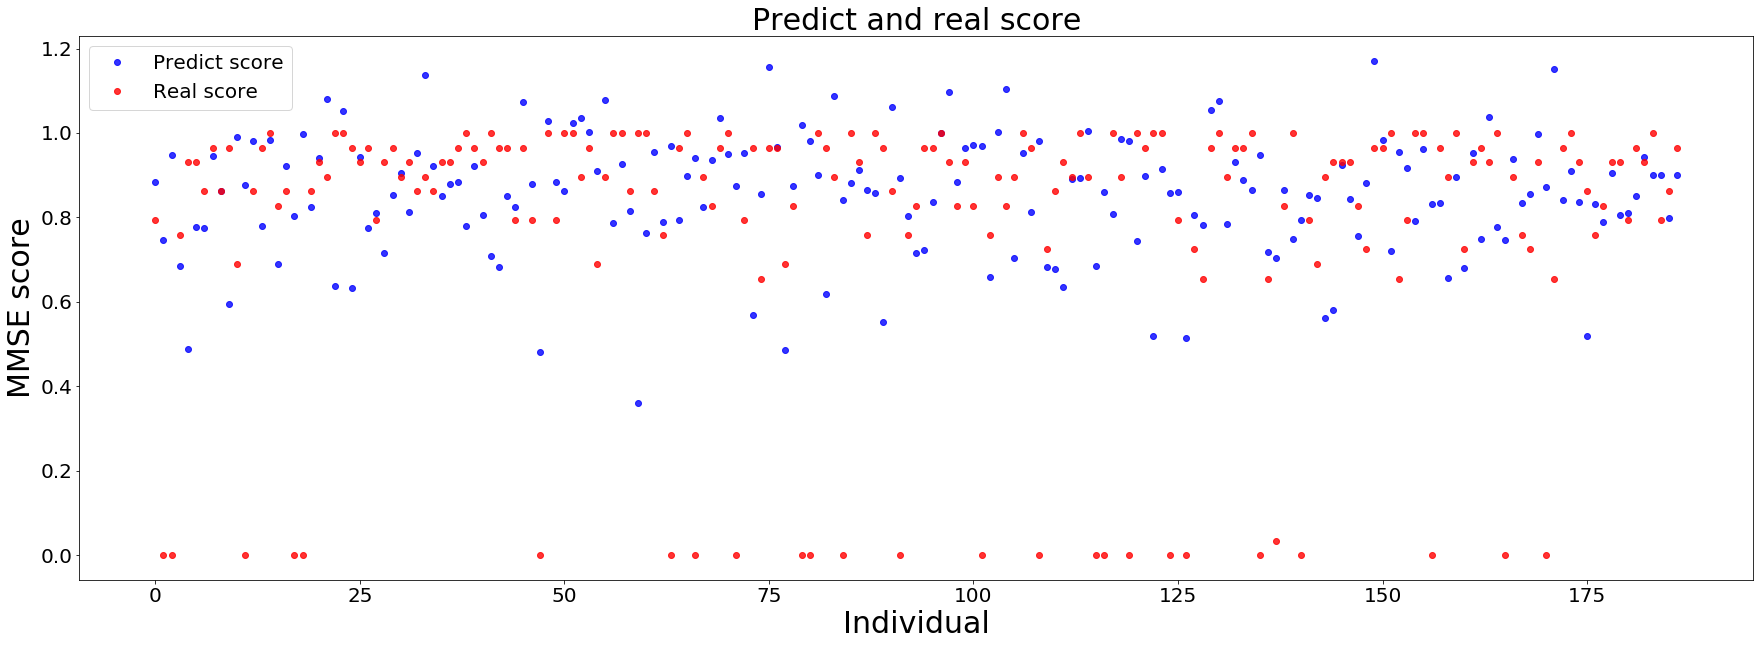

In [29]:
plt.figure(figsize=(30,10))
plt.plot(range(len(Y_test)), Y_predict, 'bo', alpha=0.8,label='Predict score')
plt.plot(range(len(Y_test)), Y_test, 'ro', alpha=0.8,label='Real score')
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)

plt.title('Predict and real score',fontsize=30)
plt.xlabel('Individual', fontsize=30)
plt.ylabel('MMSE score', fontsize=30)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda643b8d68>]],
      dtype=object)

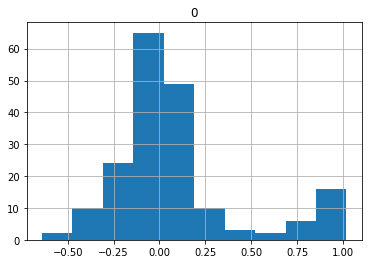

In [30]:
# difference histgram
diff = (Y_predict[:, 0] - Y_test)
pd.DataFrame(diff).hist()